In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets
import time
import copy
import pickle
import glob
import os
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

The code of semi-supervised stacked autoencoder is modified from
https://github.com/JustusvLiebig/Soft_Sensor_Experiments/tree/main/StackedAutoEncoder

which was based on:

X. Yuan, et al., A novel semi-supervised pre-training strategy for deep networks and its application for quality variable prediction in industrial processes, Chemical Engineering Science, Volume 217, 2020, 115509, ISSN 0009-2509,
https://doi.org/10.1016/j.ces.2020.115509.

In [2]:
# This cell is the Pytorch implementation of the Semisupervised stacked Autoencoder
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
class MyDataset(Dataset):
    # Initialization
    def __init__(self, data, label, unlabel_idx, mode='2D'):
        self.data, self.label, self.mode, self.unlabel_idx= data, label, mode, unlabel_idx

    # Get item
    def __getitem__(self, index):
        if self.mode == '2D':
            return self.data[index, :], self.label[index, :], self.unlabel_idx[index, :]
        elif self.mode == '3D':
            return self.data[:, index, :], self.label[:, index, :], self.unlabel_idx[:, index, :]

    # Get length
    def __len__(self):
        if self.mode == '2D':
            return self.data.shape[0]
        elif self.mode == '3D':
            return self.data.shape[1]

    def getNumpyLabel(self):
        return self.label.cpu().detach().numpy()
    def getTensorTrain(self):
        return self.data

class AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Linear(input_dim, latent_dim, bias=True)
        self.decoder = nn.Linear(latent_dim, input_dim, bias=True)
        self.y_layer = nn.Linear(latent_dim, 1, bias=True)

    def forward(self, X, decode=True):
        # Return (latent/decode output, Y estimate by dense)
        H = torch.sigmoid(self.encoder(X))
        if decode:
            return torch.sigmoid(self.decoder(H)), torch.sigmoid(self.y_layer(H))
        else:
            return H, torch.sigmoid(self.y_layer(H))

class SAE(nn.Module):
    def __init__(self,AE_list):
        super().__init__()
        self.num_AE = len(AE_list)
        self.SAE_list=[]

        for i in range(1, self.num_AE+1):
            if i != self.num_AE:
                self.SAE_list.append(AE(AE_list[i-1], AE_list[i]).to(device))
            else:
                self.SAE_list.append(AE(AE_list[-1], AE_list[-1]).to(device))
    
    def wgtFromList(self, wts_list):
        for i in range(self.num_AE):
            self.SAE_list[i].load_state_dict(wts_list[i])
    
    def forward(self, x, layer_idx, preTrain = False):
        # preTrain: previous layers' parameters are frozen 
        # preTrain -> Return (input, AE_output, y estimate)
        # !preTrain -> Return last layer's (latent, estimate)
        output = x
        if preTrain:
            if layer_idx == 0:
                inputs = output
                output, y_estimate = self.SAE_list[layer_idx](output, decode=True)                
                return inputs, output, y_estimate

            else:
                for i in range(layer_idx):
                    for param in self.SAE_list[i].parameters():
                        param.requires_grad = False
                    output,_ = self.SAE_list[i](output, decode = False)
                inputs = output
                output, y_estimate = self.SAE_list[layer_idx](output, decode=True)                
                return inputs, output, y_estimate
        else:
            for i in range(self.num_AE-1):
                for param in self.SAE_list[i].parameters():
                    param.requires_grad = True
                output, _ = self.SAE_list[i](output, decode = False)
            return self.SAE_list[-1](output, decode = False)

def loss_func(input_encode, output_latent, y_estimate,  y_label, unlabel_idx, tradeoff_param):
    N_total = unlabel_idx.size(dim=0)
    N_u = torch.sum(unlabel_idx)
    N_l = N_total - N_u
    label_idx = torch.ones(unlabel_idx.size(), dtype=int, device=device)-unlabel_idx
    if N_u != 0:
        unlabel_term = (N_total/(2*N_u))*nn.functional.mse_loss(unlabel_idx*input_encode, unlabel_idx*output_latent)
    else:
        unlabel_term = 0
    if N_l != 0:
        label_term = (N_total/(2*N_l))*(nn.functional.mse_loss(label_idx*input_encode, label_idx*output_latent)+
                    tradeoff_param*nn.functional.mse_loss(label_idx*y_estimate, label_idx*y_label))
    else:
        label_term = 0
    return unlabel_term+label_term
                                

def SAE_train(dataloader_dict, SAE_model, unsp_epochs, unsp_lr, tradeoff_param, sp_epochs, sp_lr):
    SAE_model.to(device)
    for layer_idx in range(SAE_model.num_AE):
        print('Pre-training on the {} layer'.format(layer_idx))
        # Pretraining of each layer
        optimizer = torch.optim.Adam(SAE_model.SAE_list[layer_idx].parameters(), lr = unsp_lr)
        best_layer_wts = copy.deepcopy(SAE_model.SAE_list[layer_idx].state_dict())
        best_loss = np.inf

        for epoch in range(unsp_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    SAE_model.SAE_list[layer_idx].train()
                else:
                    SAE_model.SAE_list[layer_idx].eval()
                
                for inputs, labels, unlabel_idx in dataloader_dict[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    unlabel_idx = unlabel_idx.to(device)
                    optimizer.zero_grad()
                    input_encode,output_latent,y_estimate = SAE_model(inputs,layer_idx,preTrain=True)
                    loss = loss_func(input_encode, output_latent, y_estimate, labels, unlabel_idx, tradeoff_param)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                loss= loss.item()
                if phase == 'train':
                    train_loss = loss
                else:
                    val_loss = loss
            print(f"Epoch {epoch+1}/{unsp_epochs}, train_loss: {train_loss:>7f}, val_loss: {val_loss:>7f}")
            if phase == 'val' and val_loss < best_loss:
                best_loss = val_loss
                best_layer_wts = copy.deepcopy(SAE_model.SAE_list[layer_idx].state_dict())
        SAE_model.SAE_list[layer_idx].load_state_dict(best_layer_wts)
        print(f'Best loss: {best_loss:>7f}')

    print('Start Finetuning\n')
    param_list=[]
    best_wts_list=[]
    for tmp_sub_model in SAE_model.SAE_list:
        best_wts_list.append(tmp_sub_model.state_dict())
        for tmp_param in tmp_sub_model.parameters():
            param_list.append(tmp_param)
    optimizer = torch.optim.Adam(param_list, lr=sp_lr)
    mse_loss = nn.MSELoss()
    best_loss = np.inf

    for epoch in range(sp_epochs):
        for phase in ['train', 'val']:
            sum_loss=0
            if phase == 'train':
                SAE_model.train()
            else:
                SAE_model.eval()

            for tmp_inputs, tmp_labels, unlabel_idx in dataloader_dict[phase]:
                unlabel_idx = unlabel_idx.to(device)
                if unlabel_idx.size(dim=0) == torch.sum(unlabel_idx):
                    # All data in the batch is unlabelled, bypass
                    continue
                label_idx = torch.ones(unlabel_idx.size(), dtype=int, device=device)-unlabel_idx
                inputs = torch.index_select(tmp_inputs, 0, torch.argwhere(label_idx)[:,0]).to(device)
                labels = torch.index_select(tmp_labels, 0, torch.argwhere(label_idx)[:,0]).to(device)
                optimizer.zero_grad()
                _, y_estimate = SAE_model(inputs,SAE_model.num_AE-1,preTrain=False)
                loss = mse_loss(y_estimate, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                sum_loss += loss.detach().item()
            if phase == 'train':
                train_loss = sum_loss
            else:
                val_loss = sum_loss
        print(f"Epoch {epoch+1}/{sp_epochs}, train_loss: {train_loss:>7f}, val_loss: {val_loss:>7f}")
        if phase == 'val' and val_loss < best_loss:
            best_loss = val_loss
            for AE_idx in range(SAE_model.num_AE):
                best_wts_list[AE_idx] = copy.deepcopy(SAE_model.SAE_list[AE_idx].state_dict())
    SAE_model.wgtFromList(best_wts_list)
    print('Training complete')
    #with open('wts_list', 'wb') as fp:
    #    pickle.dump(best_wts_list, fp)

In [3]:
def avgOutPoint1(df):
    #Change point 1 readings to Avg. of Point 2.
    label_list=list(df['label'])
    conc_list = list(df['AT400(CO2 %)'])
    p=0
    num=0
    i=0
    sampling2_avgcon = list()
    while i<len(label_list):
        if label_list[i]==2:
            p=p+conc_list[i]
            num=num+1
            i=i+1
        else:
            if p ==0 and num==0:
                i=i+1
                pass
            else:
                sampling2_avgcon.append(p/num)
                i =i+1
                num=0
                p=0

    i=0
    k=-1
    while i<(len(label_list)-1):
        if label_list[i]==1:
            conc_list[i]=sampling2_avgcon[k]
            i=i+1
        else:
            if label_list[i+1]==1 :
                k=k+1
                i=i+1
            else:
                i=i+1
    #set new AT400
    df['AT400(CO2 %)']=pd.Series(data=conc_list,index=df.index)
    return df

def getSampleSet(df_list, callback):
    for i in range(len(df_list)):
        # The 1st element in label list is label
        nset = df_list[i].shape[0]-callback
        print("Number of set: ", nset)
        conc_input=np.zeros((df_list[i].shape[0],6)) # Only the true reading is non-zero
        conc_set = df_list[i]['AT400(CO2 %)'].values # Excl. 1st column, label column
        #conc_set[np.isnan(conc_set)]=0
        parameter_set = df_list[i].iloc[:,:-1].values
        for k in range(conc_input.shape[0]): # Only the true reading is non-zero, default for onehot
            conc_input[k][int(df_list[i]['label'][k])-1]=1
        #conc_input[np.isnan(conc_input)]=0
        parameter_set=np.hstack((parameter_set,conc_input))
        sample_set=np.zeros((nset,(callback+1)*parameter_set.shape[1]))
        label_set=np.zeros((nset,1))
        sample_pos_set = np.zeros((nset,1))
        for j in range(nset):
            sample_set[j]=parameter_set[0+j:callback+j+1].flatten()
            label_set[j]=conc_set[callback+j]
            sample_pos_set[j] = df_list[i].iloc[callback+j,-1]
        if (i==0):
            total_sample_set=np.zeros((0,(callback+1)*parameter_set.shape[1]))
            total_label_set=np.zeros((0,1))
            total_pos_set=np.zeros((0,1))
        total_sample_set = np.vstack([total_sample_set,sample_set])
        total_label_set = np.vstack([total_label_set,label_set])
        total_pos_set = np.vstack([total_pos_set,sample_pos_set])
        
    return total_sample_set, total_label_set, total_pos_set

def getDataSet(path_list,df_list, callback, test_df_index_list):
    # Pre-processing: avg. out Conc @ sampling point 1
    print('Timestamp in selected Test df list: ')
    for i in range(len(test_df_index_list)):
        print(os.path.basename(path_list[test_df_index_list[i]]))
    for i in range(len(df_list)):
        df_list[i]=df_list[i].set_index('time')
        df_list[i] = avgOutPoint1(df_list[i])
        if (i==0):
            origin_feature_num = df_list[i].shape[1]
            print("Origin input DF feature num(excl time, incl. label): ", origin_feature_num)

    # Separate df_list into Train & Test df lists
    test_df_list = list(pd.Series(df_list)[test_df_index_list]) # The 140207_1 is selected as the testset
    train_df_list = list(pd.Series(df_list)[list(set(range(0,len(df_list),1))-set(test_df_index_list))])

    #Min-max scaler, calculated from train_df_list
    for i in range(len(train_df_list)):
        if (i==0):
            tmp_full_values=train_df_list[i].values
            tmp_conc_values=train_df_list[i]['AT400(CO2 %)'].values
        else:
            tmp_full_values=np.concatenate((tmp_full_values, train_df_list[i].values), axis=0)
            tmp_conc_values=np.concatenate((tmp_conc_values, train_df_list[i]['AT400(CO2 %)'].values), axis=0)
    tmp_full_values = tmp_full_values[:,:-1] # excl. label column as well
    general_scaler = MinMaxScaler()
    conc_scaler = MinMaxScaler()
    general_scaler.fit(tmp_full_values)
    conc_scaler.fit(tmp_conc_values.reshape(-1,1))

    print('Conc scaler max: ',conc_scaler.data_max_)
    for i in range(len(df_list)):
        df_list[i].iloc[:,:-1] = general_scaler.transform(df_list[i].iloc[:,:-1].values)
    # Separate df_list into Train & Test df lists
    test_df_list = list(pd.Series(df_list)[test_df_index_list]) # The 140207_1 is selected as the testset
    train_df_list = list(pd.Series(df_list)[list(set(range(0,len(df_list),1))-set(test_df_index_list))])

    print("train list: ", len(train_df_list))
    train_sample_set, train_label_set, train_pos_set = getSampleSet(train_df_list, callback)
    test_sample_set, test_label_set, test_pos_set = getSampleSet(test_df_list, callback)
    
    return train_sample_set, train_label_set, train_pos_set, test_sample_set, test_label_set, test_pos_set, conc_scaler, train_df_list, test_df_list

In [4]:
seed_everything(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

data_path_list = glob.glob('../03 Sample Data/033 Full Process Data/WithLabel/1*.xlsx')
list_of_origin_df=[]
for i in range(len(data_path_list)):
    xls = pd.ExcelFile(data_path_list[i])
    data_df = pd.read_excel(xls, sheet_name=0, index_col=0, header = [0,1])
    data_df.columns = data_df.columns.map(''.join)
    data_df=data_df.rename_axis('time').reset_index()
    tmp_name=list(data_df.columns)
    tmp_name[-1]='label'
    data_df.columns=tmp_name
    list_of_origin_df.append(data_df)
test_df_index_list=[1,2]
callback=17
target_label=6
list_of_processed_df=list_of_origin_df.copy()

Using cuda device
PyTorch Version:  1.11.0
Torchvision Version:  0.12.0


In [5]:
train_sample_set, train_label_set, train_pos_set, test_sample_set, test_label_set, test_pos_set, conc_scaler, train_df_list, test_df_list \
=getDataSet(data_path_list,list_of_processed_df, callback,test_df_index_list)
train_unlabel_set = np.ones((train_pos_set.shape[0],1))-(train_pos_set == target_label).astype(int)
test_unlabel_set = np.ones((test_pos_set.shape[0],1))-(test_pos_set == target_label).astype(int)
n_set = train_sample_set.shape[0]
print('train_sample_set shape: ', train_sample_set.shape)

train_index = list(set(range(0,n_set,1))- set(range(0,n_set,5)))
test_index = list(set(range(0,n_set,5)))
x_train = train_sample_set[train_index]; x_val = train_sample_set[test_index]
y_train = train_label_set[train_index]; y_val = train_label_set[test_index]
x_test = test_sample_set; y_test = test_label_set
train_unlabel = train_unlabel_set[train_index]; val_unlabel = train_unlabel_set[test_index]
test_unlabel = test_unlabel_set
print('Train len: %d, Val len: %d' %(x_train.shape[0], x_val.shape[0]))
print('x_train shape: '+str(x_train.shape)+ ', y_train shape:' + str(y_train.shape))

Timestamp in selected Test df list: 
140206.xlsx
140207_1.xlsx
Origin input DF feature num(excl time, incl. label):  91
Conc scaler max:  [12.03671837]
train list:  6
Number of set:  100
Number of set:  33
Number of set:  50
Number of set:  33
Number of set:  201
Number of set:  211
Number of set:  33
Number of set:  101
train_sample_set shape:  (628, 1728)
Train len: 502, Val len: 126
x_train shape: (502, 1728), y_train shape:(502, 1)


In [6]:
print(np.sum(train_unlabel), np.sum(val_unlabel), np.sum(test_unlabel))
print(train_unlabel.shape[0], val_unlabel.shape[0], test_unlabel.shape[0])

405.0 101.0 110.0
502 126 134


In [7]:
denoise = True
if denoise:
    noise_factor = 0.1
    scale_arr = np.var(x_train,axis=0)
    x_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=scale_arr, size=x_train.shape) 
    x_val = x_val + noise_factor * np.random.normal(loc=0.0, scale=scale_arr, size=x_val.shape) 

train_dataset = MyDataset(torch.tensor(x_train, dtype=torch.float32, device=device),
                          torch.tensor(y_train, dtype=torch.float32, device=device),
                          torch.tensor(train_unlabel, dtype=torch.int, device=device))
val_dataset = MyDataset(torch.tensor(x_val, dtype=torch.float32, device=device),
                          torch.tensor(y_val, dtype=torch.float32, device=device),
                          torch.tensor(val_unlabel, dtype=torch.int, device=device))
test_dataset = MyDataset(torch.tensor(x_test, dtype=torch.float32, device=device),
                          torch.tensor(y_test, dtype=torch.float32, device=device),
                          torch.tensor(test_unlabel, dtype=torch.int, device=device))
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
dataloader_dict ={'train' : train_dataloader, 'val' : val_dataloader}

In [8]:
num_layer0 = int(train_sample_set.shape[1])
num_layer1 = int(64*(callback+1))
num_layer2 = int(0.5*num_layer1)
num_layer3 = int(0.25*num_layer2)
num_layer4 = int(0.25*num_layer3)
num_layer5 = int(0.25*num_layer4)
num_layer6 = int(0.25*num_layer5)
#num_layer7 = int(0.5*num_layer6)
print(num_layer0,num_layer1,num_layer2,num_layer3,num_layer4,num_layer5)

1728 1152 576 144 36 9


In [9]:
myModel = SAE(AE_list=[num_layer0,num_layer1,num_layer2])
#SAE_train(dataloader_dict , myModel, 200, 0.001, 1.5, 500, 0.0005)
SAE_train(dataloader_dict , myModel, 10, 0.001, 1.5, 100, 0.001)

Pre-training on the 0 layer
Epoch 1/10, train_loss: 0.274694, val_loss: 0.360348
Epoch 2/10, train_loss: 0.212533, val_loss: 0.360310
Epoch 3/10, train_loss: 0.222886, val_loss: 0.356542
Epoch 4/10, train_loss: 0.223540, val_loss: 0.353999
Epoch 5/10, train_loss: 0.205449, val_loss: 0.351239
Epoch 6/10, train_loss: 0.189916, val_loss: 0.345675
Epoch 7/10, train_loss: 0.175597, val_loss: 0.340942
Epoch 8/10, train_loss: 0.166046, val_loss: 0.338873
Epoch 9/10, train_loss: 0.158301, val_loss: 0.337953
Epoch 10/10, train_loss: 0.150839, val_loss: 0.336400
Best loss: 0.336400
Pre-training on the 1 layer
Epoch 1/10, train_loss: 0.160562, val_loss: 0.042044
Epoch 2/10, train_loss: 0.073788, val_loss: 0.042512
Epoch 3/10, train_loss: 0.059818, val_loss: 0.029071
Epoch 4/10, train_loss: 0.060143, val_loss: 0.031526
Epoch 5/10, train_loss: 0.062600, val_loss: 0.024397
Epoch 6/10, train_loss: 0.058863, val_loss: 0.024049
Epoch 7/10, train_loss: 0.053191, val_loss: 0.021673
Epoch 8/10, train_loss

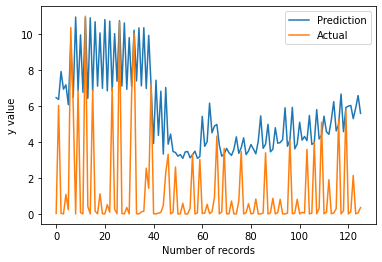

In [10]:
myModel.eval()
with torch.no_grad():
    _,pred = myModel(torch.tensor(x_val, dtype=torch.float32, device=device),0)
plt.plot(conc_scaler.inverse_transform(pred.cpu().detach().numpy()), label='Prediction')
plt.plot(conc_scaler.inverse_transform(y_val), label='Actual')
plt.xlabel('Number of records')
plt.ylabel('y value')
plt.legend()

In [11]:
#np.save('set3_val_'+str(target_label)+'.npy',conc_scaler.inverse_transform(pred.cpu().detach().numpy()))